### Analysis packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

### Load the data

In [2]:
trainset = pd.read_csv('Input/train.csv')
testset = pd.read_csv('Input/test.csv')

### Few quick observations

we can make few observations baesd on the data description in the competition:
- Few groups are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). The ind indicates most probably individual, reg is probably registration, car is self-explanatory, calc suggests a calculated field;
- The postfix bin is used for binary features;
- The postfix cat to is used for categorical features;
- Features without the bin or cat indications are real numbers (continous values) of integers (ordinal values);
- A missing value is indicated by -1;
- The value that is subject of prediction is in the target column. This one indicates whether or not a claim was filed for that insured person;
- id is a data input ordinal number.<br>


Let's glimpse the data to see if these interpretations are confirmed.

In [3]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


Indeed, we can observe the <b>cat</b> values are <b>categorical</b>, <br>
integer values ranging from <b>0</b> to <b>n</b>, <b>bin</b> values are <b>binary</b> (either 0 or 1).

Let's see how many rows and columns are in the data.

In [4]:
print("Train dataset (rows,cols) :", trainset.shape, "\nTest dataset (rows, cols) : ", testset.shape)

Train dataset (rows,cols) : (595212, 59) 
Test dataset (rows, cols) :  (892816, 58)


There are 59 columns in the training dataset and only 58 in the testing dataset. Since from this dataset should have been extracted the target, this seems fine. Let's check the difference between the columns set in the two datasets, to make sure everything is fine.

In [5]:
print('Columns in train and not in test dataset :', set(trainset.columns) - set(testset.columns))

Columns in train and not in test dataset : {'target'}


In [6]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

### Introduction of metadata

To make easier the manipulation of data, we will associate few meta-information to the variables in the trainset. This will facilitate the selection of various types of features for analysis, inspection or modeling. We are using as well a <b>category</b> field for the car, ind, reg and calc types of features.

What metadata will be used:

- <b>use</b>: input, ID, target
- <b>type</b>: nominal, interval, ordinal, binary
- <b>preserve</b>: True or False
- <b>dataType</b>: int, float, char
- <b>category</b>: ind, reg, car, calc

In [7]:
# uses code from https://www.kaggle.com/bertcarremans/data-preparation-exploration (see references)
data = []
for feature in trainset.columns:
    # Defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
         
    # Defining the type
    if '_bin' in feature or feature == 'target':
        type = 'binary'
    elif '_cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == 'float64':
        type = 'real'
    elif trainset[feature].dtype == 'int64':
        type = 'integer'
        
    # Initialize preserve to True for all variables except for id
    preserve = True
    if feature == 'id':
        preserve = False
    
    # Defining the data type 
    dtype = trainset[feature].dtype
    
    category = 'none'
    # Defining the category
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    
    # Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category' : category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


We can extract, for example, all categorical values:

In [8]:
metadata[(metadata.type == 'categorical') &(metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

Let's inspect all features, to see how many category distinct values do we have:

In [9]:
pd.DataFrame({'count':metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


We have 20 calculated features, 16 car, 18 individual and 3 registration.

Let's inspect now all features, to see how many use and type distinct values do we have:

In [10]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


There are one nominal feature (the id), 20 binary values, 21 real (or float numbers), 16 categorical features - all these being as well input values and one target value, which is as well binary, the target.

### Data analysis and statistics

#### Target variable

<Figure size 432x288 with 0 Axes>

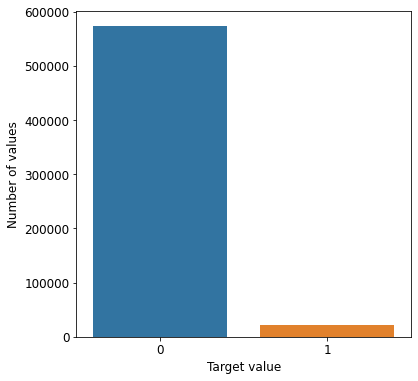

In [11]:
plt.figure()
fig, ax = plt.subplots(figsize = (6,6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

# Bar plot
# Order the bars descending on target mean
sns.barplot(x = x, y= y,ax = ax )
plt.ylabel('Number of values',fontsize = 12)
plt.xlabel("Target value",fontsize = 12)
plt.tick_params(axis = 'both',which = 'major',labelsize = 12)
plt.show()

Only 3.64% of the target data have 1 value. This means that the training dataset is highly imbalanced. We can either undersample the records with target = 0 or oversample records with target = 1; because is a large dataset, we will do undersampling of records with target = 0.

### Real features

In [12]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [13]:
# pow ; 제곱승
(pow(trainset['ps_car_12']*10,2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [14]:
(pow(trainset['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

<h3>Features with missing values</h3>
<b>ps_reg_o3, ps_car_12, ps_car_14</b> have missing values (their minimum value is -1)

<h3>Registration features</h3>
<b>ps_reg_01 and ps_reg_02</b> are fractions with denominator 10 (values of 0.1, 0.2, 0.3 )

<h3>Car features</h3>
<b>ps_car_12</b> are (with some approximations) square roots (divided by 10) of natural numbers whilst <b>ps_car_15</b> are square roots of natural numbers. Let's represent the values using pairplot.

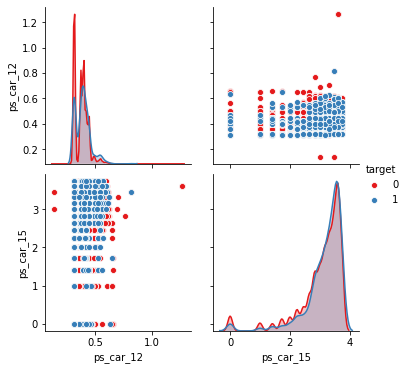

In [15]:
sample = trainset.sample(frac = 0.05)
var = ['ps_car_12','ps_car_15','target']
sample = sample[var]
sns.pairplot(sample,hue = 'target',palette = 'Set1',diag_kind = 'kde')
plt.show()

<h3>Calculated features</h3>
The features <b>ps_calc_01, ps_calc_02</b> and <b>ps_calc_03</b> have very similar distributions and could be some kind of ratio, since the maximum value is for all three 0.9. The other calculated values have maximum value an integer value (5,6,7, 10,12)

Let's visualize the real features distribution using density plot

locs, labels = xticks()  # Get the current locations and labels.


<Figure size 432x288 with 0 Axes>

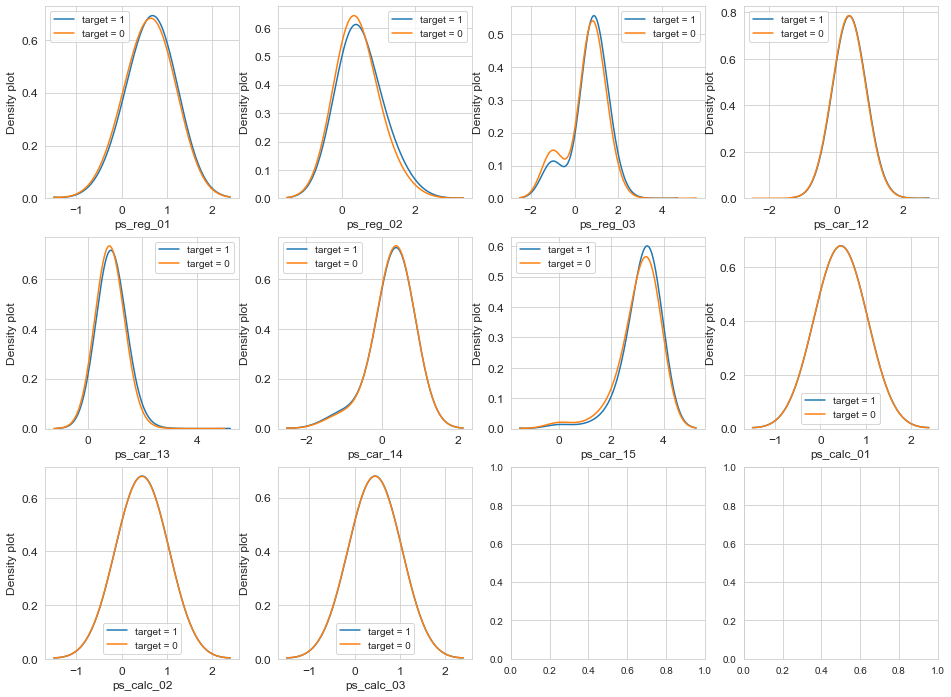

In [16]:
var = metadata[(metadata.type =='real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize  = (16,12))

for feature in var:
    i += 1
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature],bw = 0.5, label = 'target = 1')
    sns.kdeplot(t0[feature],bw = 0.5,label = 'target = 0')
    plt.ylabel('Density plot',fontsize = 12)
    plt.xlabel(feature,fontsize = 12)
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'both',which = 'major',labelsize = 12)
plt.show();

ps_reg_02, ps_car_13, ps_car_15 shows the most different distributions between sets of values associated with target=0 and target=1

Let's visualize the correlation between the real features

<b>랜덤 샘플의 추출</b><br>
sample() -> 하이퍼 파라미터 설명<br>
 n : 추출할 샘플의 수(frac과 중복사용 불가)<br>
 frac : 전체 개수의 비율만큼 샘플을 반환할 경우 사용된다.(n과 중복사용 불가)<br>
 replace : 샘플링을 수행할 때 같은 샘플을 중복되게 추출할 지 여부를 결정 ~ > 기본값은 False, 중복샘플 허용 X <br>
 weights : 샘플 추출시 샘플마다 뽑힐 확률을 조정<br>
 random_state : 랜덤 샘플 추출시 시드를 입력,,<br>
 axis : 샘플을 추출할 방향(행 혹은 열)을 입력받는다.<br>
 -> 기본값은 0,, 행을 선택.. 1이 입력될 경우 열을 선택

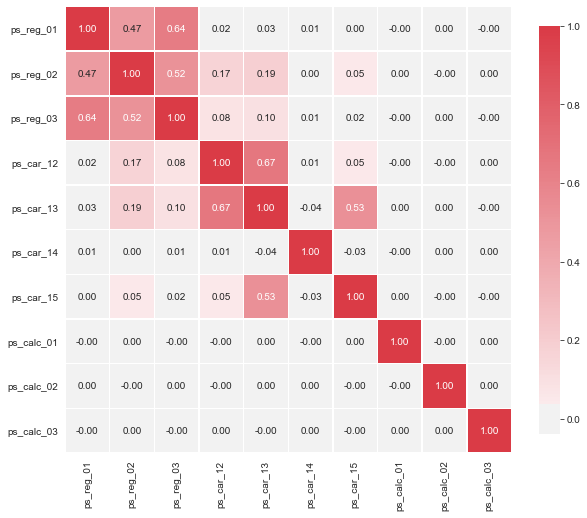

In [17]:
def corr_heatmap(var):
    correlations = trainset[var].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)


Let's visualize the plots of the variables with strong correlations. These are:

- ps_reg_01 with ps_reg_02 (0.47);
- ps_reg_01 with ps_reg_03 (0.64);
- ps_reg_02 with ps_reg_03 (0.52);
- ps_car_12 with ps_car_13 (0.67);
- ps_car_13 with ps_car_15 (0.53);
<br>

To show the pairs of values that are correlated we use pairplot. Before representing the pairs, we subsample the data, using only 2% in the sample.

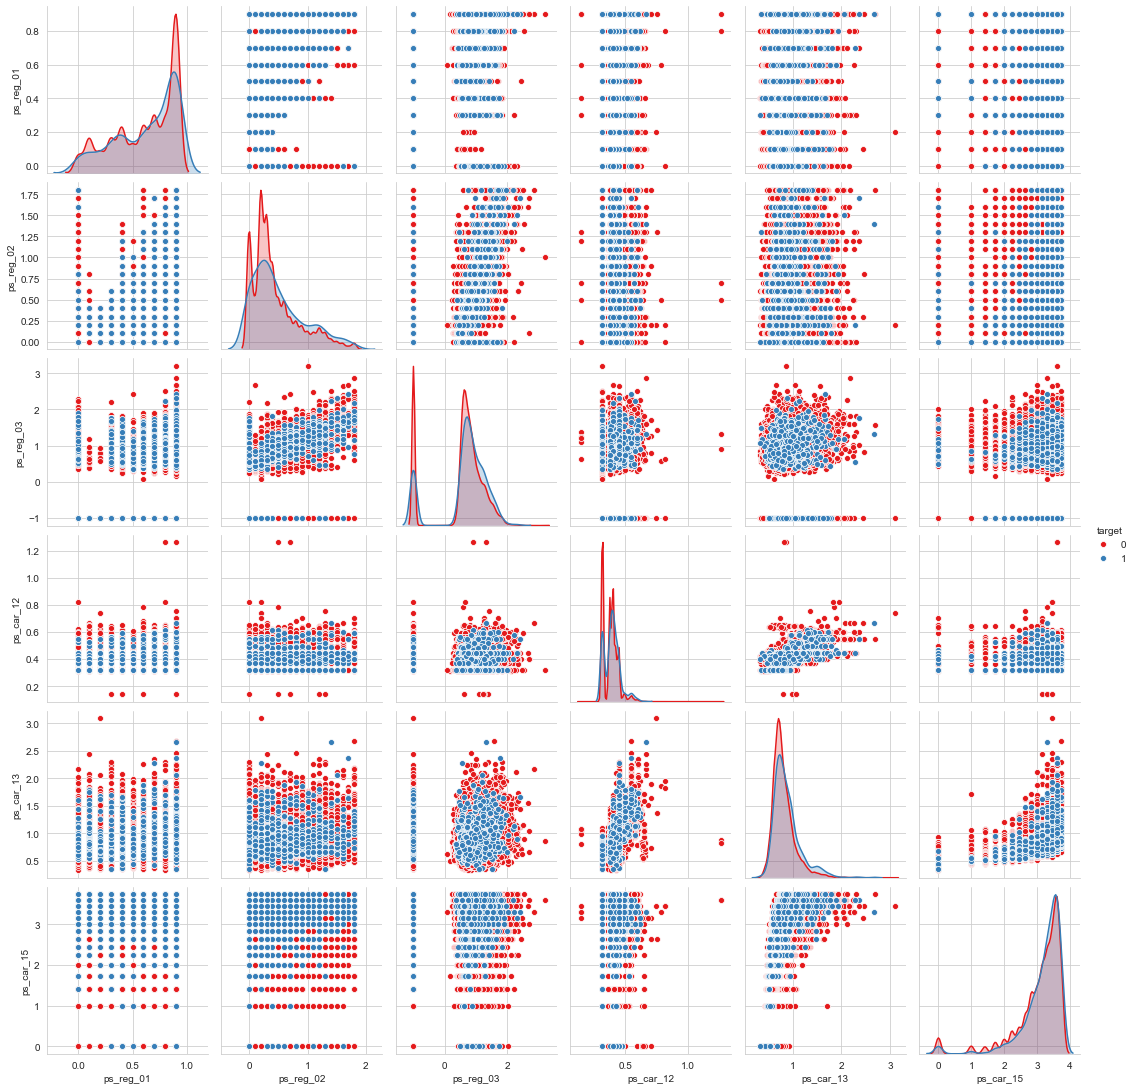

In [18]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

### Binary features

In [19]:
v = metadata[(metadata.type =='binary')&(metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's plot the distribution of the binary data in the training dataset. With blue we represent the percent of 0 and with red the percent of 1.

In [20]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100)
    one_list.append((trainset[col]==1).sum() / trainset.shape[0]*100)

(trainset['ps_ind_06_bin']==0).sum() : 값이 0인 데이터 개수

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x000000DCBD2C35C8> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

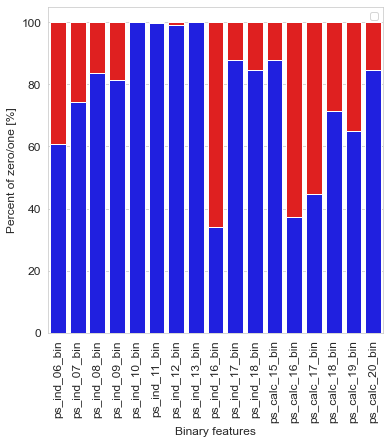

In [28]:
plt.figure()
fig, ax = plt.subplots(figsize = (6,6))
# Bar plot
p1 = sns.barplot(ax = ax,x = bin_col,y = zero_list, color = 'blue')
p2 = sns.barplot(ax = ax, x = bin_col,y = one_list,bottom = zero_list,color = 'red')
plt.ylabel('Percent of zero/one [%]',fontsize = 12)
plt.xlabel('Binary features',fontsize = 12)
locs,labels = plt.xticks()
plt.setp(labels,rotation = 90)
plt.tick_params(axis = 'both', which = 'major',labelsize = 12)
plt.legend((p1,p2),('Zero',"One"))
plt.show()

ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin and ps_ind_13_bin have very small number of values 1 (lesss than 0.5%) whilst the number of value 1 is very large for ps_ind_16_bin and ps_cals_16_bin (more than 60%).

Let's see now the distribution of binary data and the corresponding values of target variable.

<Figure size 432x288 with 0 Axes>

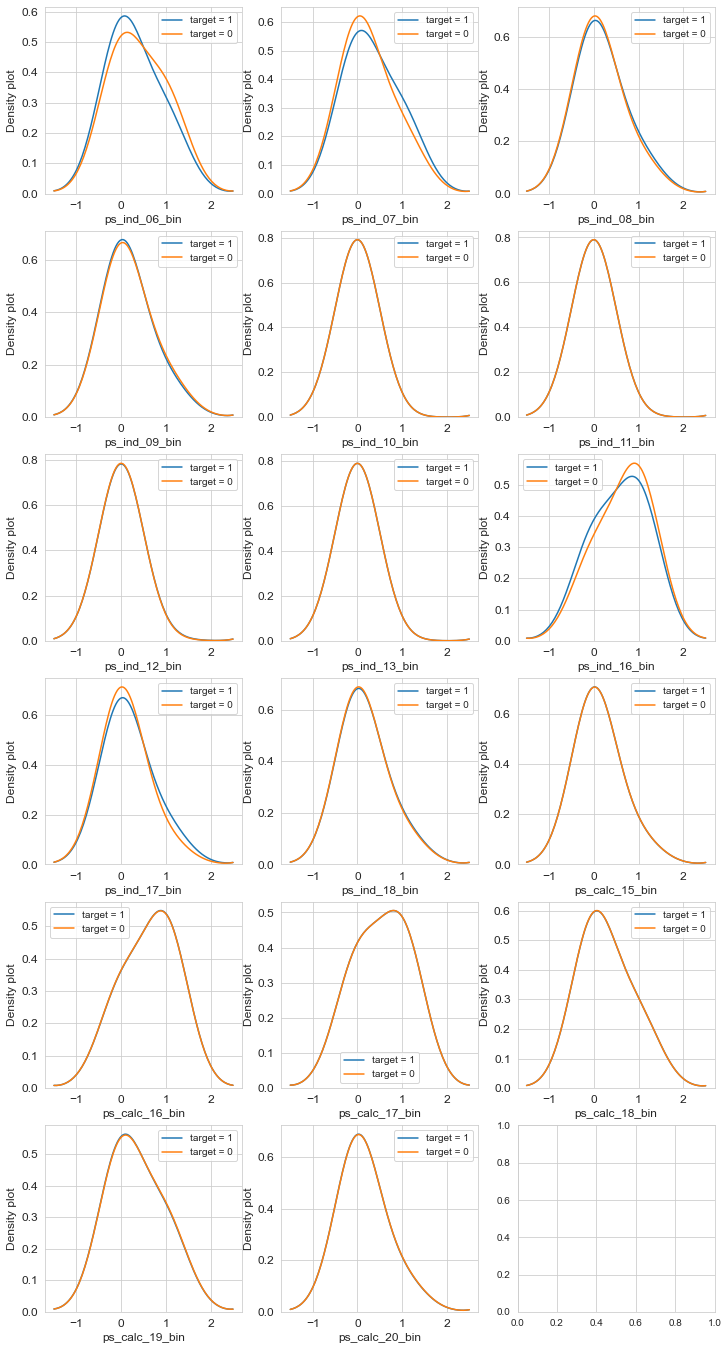

In [29]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3,figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6,3,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

ps_ind_06_bin, ps_ind_07_bin, ps_ind_16_bin, ps_ind_17_bin shows high inbalance between distribution of values of 1 and 0 for values of target equals with 1 and 0, ps_ind_08_bin shows a small inbalance whilㅡe the other features are well balanced, having similar density plots.

<h2>Categorical features</h2>


We will represent the distribution on categorical data in two ways. First, we calculate the percentage of target=1 per category value and represent these percentages using bar plots.

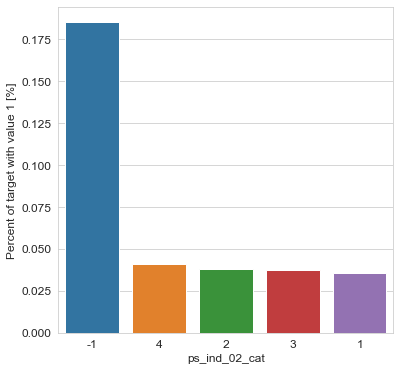

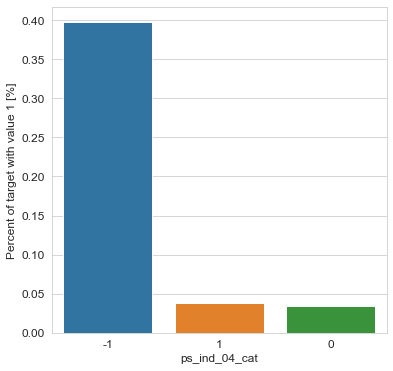

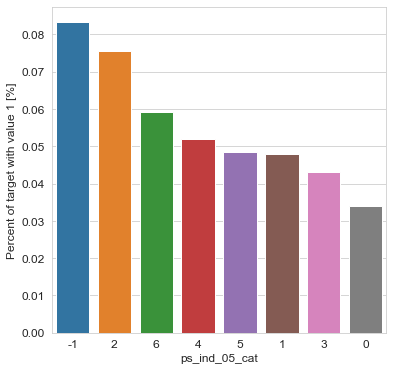

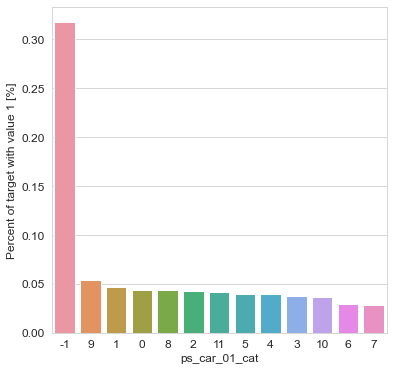

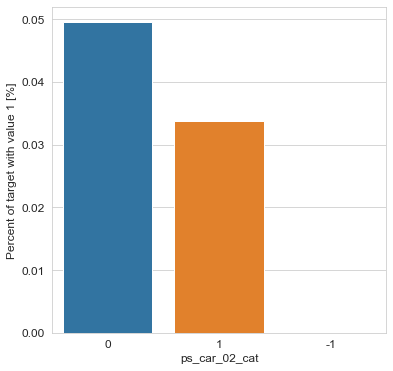

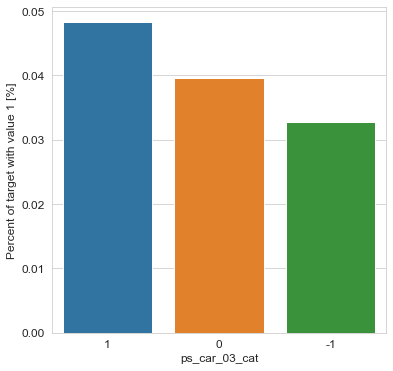

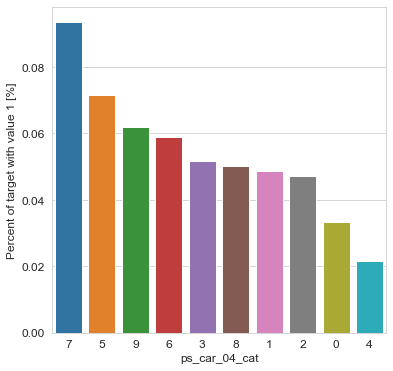

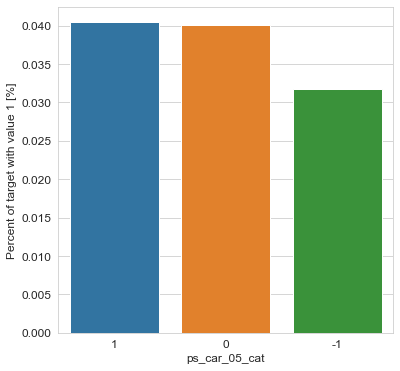

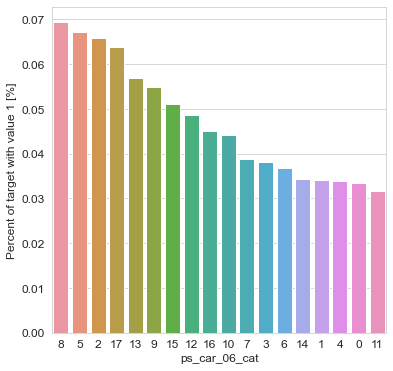

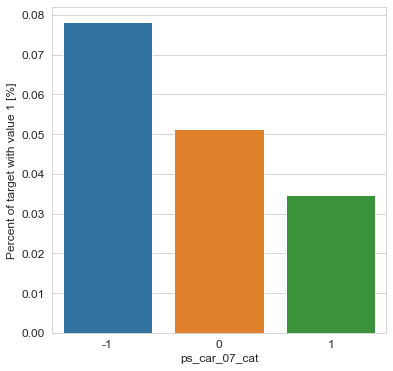

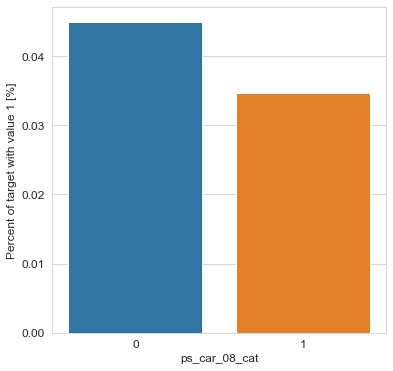

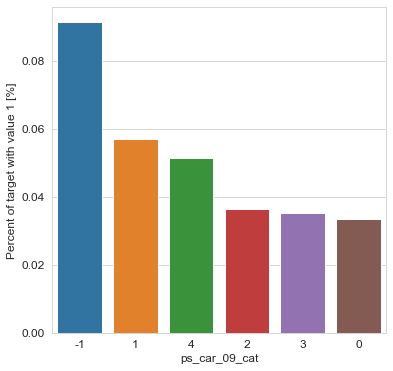

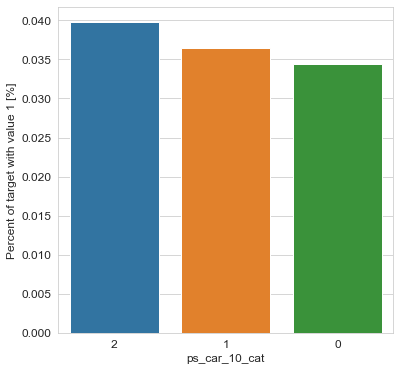

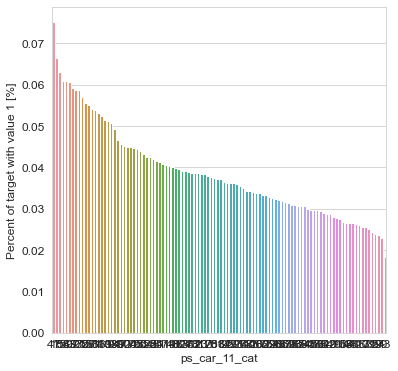

In [33]:
var = metadata[(metadata.type =='categorical') & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize = (6,6))
    
    # Calculate the percentage of target =1 per category value
    cat_perc = trainset[[feature,'target']].groupby([feature],as_index = False).mean()
    cat_perc.sort_values(by = 'target',ascending = False,inplace = True)
    
    # Bar plot
    # Order the bars descedning on target mean
    sns.barplot(ax = ax ,x = feature,y = 'target',data = cat_perc,order = cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]',fontsize = 12)
    plt.xlabel(feature,fontsize = 12)
    plt.tick_params(axis = 'both',which = 'major',labelsize = 12)
    plt.show();

Alternativelly we represent the categorical features using density plot. We select values with target=0 and target=1 and represent both density plots on the same graphic.

Kde에 대한 이해 : https://darkpgmr.tistory.com/147

In [ ]:
var = metadata[(metadata.type =='categorical') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target']!=0]
t0 = trainset.loc[trainset['target']==0]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,4,figsize = (16,16))